In [ ]:
# TODO: save np.arrays as h5 files instead of .npy
# TODO: generator input deep learning
# TODO: post processing: reconstruct image from network output and create shape files
# TODO: contruct my own f1 score definition, perhaps take iou=0.5 per polygon. 

In [101]:
from datetime import datetime
import sys
import geopandas as gpd
import pandas as pd
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
from os.path import join
import descartes
from PIL import Image
import h5py

import fiona 
import pyproj
import time
import yaml

import warnings
from importlib import reload

#import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)

import keras
from keras.utils import Sequence
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks as keras_cb 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

# see: https://github.com/karolzak/keras-unet
from keras_unet.models import satellite_unet 
from keras_unet.losses import jaccard_distance
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.utils import get_augmented

from keras import backend as K

# # prevent Tensorflow memory leakage
# K.clear_session()

#warnings.simplefilter("ignore")
print(sys.executable)

from src import load_data as ld
from src import preprocessing as pp
from src import prepare_for_network as pfn
from src import utils as utl

/Users/jurriaan/opt/anaconda3/envs/conda_unosatenv/bin/python


In [5]:
# local paths, set your own path here
path_main = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge'
path_data_main = utl.make_dir(join(path_main, "data"))

#### put data in these dirs

# I choose:
# Training: Mosul, Najaf, Nasiryah
# Validation: Souleimaniye
# Test: Bagdad, Kirkouk, Samawah, Tikrit (no labels present)
path_data_local_dev = join(path_data_main,'Z_Dev_Dataset')
path_data_local_train = join(path_data_main, 'Train_Dataset')
path_data_local_val = join(path_data_main, 'Validation_Dataset')
path_data_local_test = join(path_data_main, 'Evaluation_Dataset')

path_model =  utl.make_dir(join(path_data_main, 'model_{}'.format(utl.datetime_now())))
path_checkpoints =  utl.make_dir(join(path_model, 'checkpoints'))

In [6]:
# other dirs are made automatically
dir_temp_data =  utl.make_dir(join(path_data_main, 'data_temp'))
dir_temp_train = utl.make_dir(join(dir_temp_data, 'train'))
dir_temp_val = utl.make_dir(join(dir_temp_data, 'val'))
dir_temp_dev = utl.make_dir(join(dir_temp_data, 'data_dev'))
dir_temp_eval = utl.make_dir(join(dir_temp_data, 'evaluation'))
dir_temp_plots = utl.make_dir(join(dir_temp_data, 'plots_preprocessing'))

In [110]:
# settings preprocessing
quantile_clip_max = 0.999
patch_size = (512, 512)
dtype = np.float16 # 'i1'
dtype_labels = 'i1'
inv_stride = 2

a_l=1
b_l=0.1

## choose train / val data

In [5]:
#TODO:
# train_data = ['Mosul', 'Najaf', 'Nasiryah']
# val_data = ['Souleimaniye']

## Load and preprocess data

All files in 'Train_Dataset' are automatically selected for training (saved in sub dir 'whole'). All files in 'Validation_Dataset' are automatically selected for validation. All files in 'Evaluation_Dataset' are automatically selected for testing.<br>
Data (.tif files) and labels (.shp files) are both converted to .hdf5 files. First preprocessing is done for the .tif files (clip at quantile 'quantile_clip_max'). The label files become mask arrays, with 1=urban area and 0=non-urban area.

### develop (don't run for pipeline)

#### HDF5

In [ ]:
def pad_zeros_xy_single_side(arr, size_sub_sample):
    shape_x, shape_y = arr.shape
    dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
    dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]

    arr_zeros_stack_x = np.zeros((dim_x_add, shape_y), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    print("arr.shape:", arr.shape)
    return arr


def pad_zeros_xy(arr, dim_x_add, dim_y_add, both_sides=False):
    """make array dimension a multiple of sub_sample_shape
    """
    arr_zeros_stack_x = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    if both_sides:
        arr = np.concatenate((arr_zeros_stack_x, arr), axis=0)
        
    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    
    if both_sides:
        arr =  np.concatenate((arr_zeros_stack_y, arr), axis=1)
    
    #print('new shape:', arr.shape)
    return arr




In [ ]:
dtype = 'i8'
#dtype = 'i16'
sub_sample_shape = (512, 512)
dict_paths = ld.paths_in_dict(path_data_local_train)
file_hfd5 = join(dir_temp_dev,  'testrun_X.hdf5')

In [ ]:
# preprocessing with hdf5
dtype = 'i8'
dict_paths = ld.paths_in_dict(path_data_local_train)
path_file_hfd5 = join(dir_temp_train,  'groups_test_X.hdf5')

with h5py.File(file_hfd5, 'w') as f:
    for area in dict_paths:
        print(area)
        i = 0
        #g = f.create_group(area)
        dir_save_plots = utl.make_dir(join(dir_temp_plots, area))        
        
        for season in ld.seasons_fixed_order:
            for pol in sorted(dict_paths[area]['tif'][season]):
                print(' ', season, pol)
                path_raster = dict_paths[area]['tif'][season][pol]
                np_arr_processed = pp.process_image(rio.open(path_raster).read()[0], 
                                                    quantile_clip_max,
                                                    clip_min=0, 
                                                    plotting=True, 
                                                    dir_save_plots=dir_save_plots,
                                                    area=area,  season=season, pol=pol)

                shape_x, shape_y = np_arr_processed.shape
                dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
                dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]
                
                #np_arr_processed = pad_zeros_xy(np_arr_processed, dim_x_add, dim_y_add)
                #np_arr_shape_new = np_arr_processed.shape + (1,)
                stacked_shape = (shape_x + dim_x_add, shape_y + dim_y_add)  + (8,)        
                
                if i == 0:
                    dset = f.create_dataset(area, 
                                            stacked_shape,
                                            dtype=dtype,
                                            chunks=True)
                    print(' shape init', dset.shape)
                    
                dset[:, :, i] = pad_zeros_xy(np_arr_processed, dim_x_add, dim_y_add)
                i += 1
                
        print("shape dataset:", dset.shape)

In [ ]:
with h5py.File(path_file_hfd5, 'r') as f:
    for k in f.keys():
        print(k)

In [ ]:
file_hfd5_labels = join(dir_temp_dev, 'testrun_Y.hdf5')
dict_paths = ld.paths_in_dict(path_data_local_train)


In [ ]:
def shp2polygons(dict_paths):
    dict_polygons = dict()   
    for area in dict_paths:
        path_shape = dict_paths[area]['shp']
        dict_polygons[area] = gpd.read_file(path_shape)
    return dict_polygons
                
def preprocess_shape(dict_paths, file_hfd5_labels, sub_sample_shape):
    with h5py.File(file_hfd5_labels, 'w') as f:
        for area in dict_paths:
            print(area)

            dict_polygons = shp2polygons(dict_paths)

            # raster obj only required for shape and crs, this is season or pol independent
            path_raster = dict_paths[area]['tif']['spring']['vh']
            raster_obj = rio.open(path_raster)
            arr_shape = raster_obj.shape

            dim_x_add = sub_sample_shape[0] - arr_shape[0] % sub_sample_shape[0]
            dim_y_add = sub_sample_shape[1] - arr_shape[1] % sub_sample_shape[1]       
            arr_new_shape = (arr_shape[0] + dim_x_add,  arr_shape[1] + dim_y_add)

            dset = f.create_dataset(area, 
                                    arr_new_shape,
                                    dtype=dtype,
                                    chunks=True)

            dset[:] = pad_zeros_xy(pp.polygons_2_np_arr_mask(dict_polygons[area], 
                                                                 raster_obj),
                                   dim_x_add,
                                   dim_y_add
                                  )       

### Training data

In [8]:
t0 = time.time()
dict_paths_train = ld.paths_in_dict(path_data_local_train)

file_hfd5_train_X = join(dir_temp_train, 'MosNajNaS_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_Y = join(dir_temp_train, 'MosNajNaS_20191223_Y_{}.hdf5'.format(patch_size[0]))

pp.preprocces_data(dict_paths_train, file_hfd5_train_X, quantile_clip_max, patch_size, dtype, dir_temp_plots,
                    apply_log=True, a_l=1, b_l=0.2)
pp.preprocess_shape(dict_paths_train, file_hfd5_train_Y, patch_size, dtype_labels)

print('takes {} mins'.format(round((time.time() - t0)/60)))

Mosul
  winter vh
 shape init (11264, 11264, 8)
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
shape dataset: (11264, 11264, 8)
Najaf
  winter vh
 shape init (11264, 11264, 8)
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
shape dataset: (11264, 11264, 8)
Nasiryah
  winter vh
 shape init (11264, 11264, 8)
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
shape dataset: (11264, 11264, 8)
Mosul
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 4316046

Najaf
polygon mask shape: (10980, 10980)
sum polygon_mask_int: 3709703

Nasiryah
polygon mask shape: (10980, 10979)
sum polygon_mask_int: 1228702

takes 11 mins


#### check result

In [78]:
with h5py.File(file_hfd5_train_X, 'r') as f_X:
    print(f_X.keys())

<KeysViewHDF5 ['Mosul', 'Najaf', 'Nasiryah']>


In [79]:
area = 'Mosul'
with h5py.File(file_hfd5_train_X, 'r') as f_X:
    dataset_X  = f_X[area]
    X = dataset_X[:,:,0]
    print('dataset_X shape:', dataset_X.shape)

print('X shape', X.shape)
print(np.min(X), np.max(X), np.median(X), np.mean(X))

dataset_X shape: (11264, 11264, 8)
X shape (11264, 11264)
0 65535 5116.0 6381.795560694923


In [80]:
set_X = set(list(X.flatten()))
len(set_X)

65523

labels shape: (11264, 11264)
0 1 0.0 0.034017373707668844


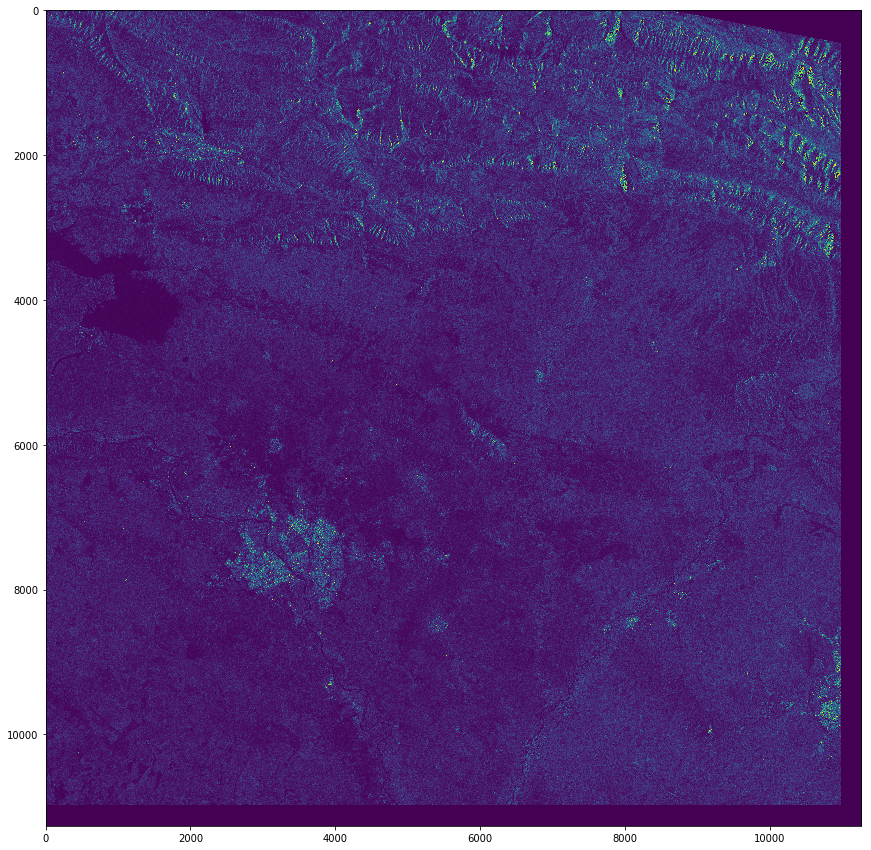

In [81]:
# check 
with h5py.File(file_hfd5_train_Y, 'r') as f_Y:
    dataset_Y  = f_Y[area]
    labels = dataset_Y[:]
    print('labels shape:', labels.shape)

print(np.min(labels), np.max(labels), np.median(labels), np.mean(labels))
fig, ax = plt.subplots(figsize=(15,15))
#ax.contour(labels, 1, colors='r')
ax.imshow(X)
#ax.imshow(labels)



In [ ]:
#large
fig, ax = plt.subplots(figsize=(150, 150))
#ax.imshow(polygon_mask, cmap='pink')
ax.contour(labels, 1, colors='red', linewidths=0.5)
ax.imshow(X)
fig.savefig(join(dir_temp_val, 'file_hfd5_val_X_{}.png'.format(area)))

In [37]:
arr_split = pfn.split_array_2D(X, 512, 512)
arr_split.shape

(484, 512, 512)

In [ ]:
def zero_padding_2(arr, dim_str, inv_stride, patch_size):
    """ padding array to fit stride
    """
    if dim_str:
        if 'x' in dim_str:
            dim_x_add = int(np.ceil(patch_size[0] / inv_stride))
            arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=0)
            arr = np.concatenate((arr_zeros_stack, arr), axis=0)
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(patch_size[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)
    return arr

In [115]:
def split_array_2D(array, nrows, ncols):
    """Split a matrix into sub-matrices of shape (nrows, ncols)"""
    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

In [ ]:
X.

In [186]:
arr_0pad = pfn.zero_padding_2(X, 'y', 2, (512,512))
arr_0pad.shape

(11264, 11776)

In [187]:
r, h = arr_0pad.shape
nrows=512
ncols=512
arr1 = arr_0pad.reshape(r//nrows, nrows, -1, ncols).swapaxes(1, 2)#.reshape(-1, nrows, ncols)
arr1.shape

(22, 23, 512, 512)

TypeError: Invalid dimensions for image data

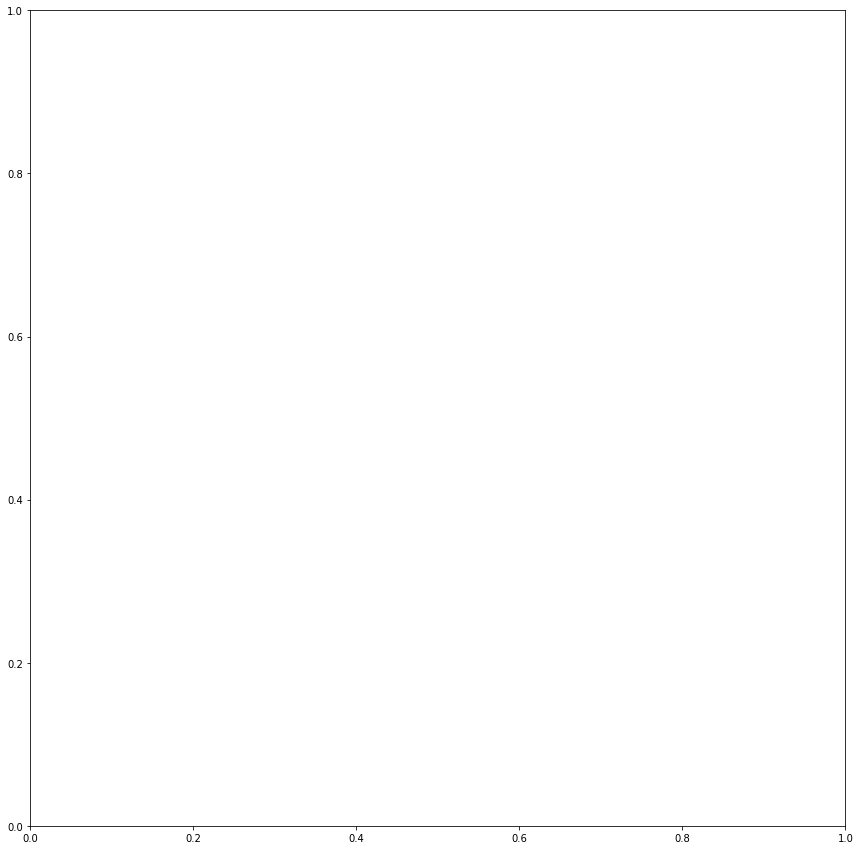

In [188]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(arr1[1])


In [118]:
arr_split = pfn.split_array_2D(arr_0pad, 512, 512)
arr_split.shape

(506, 512, 512)

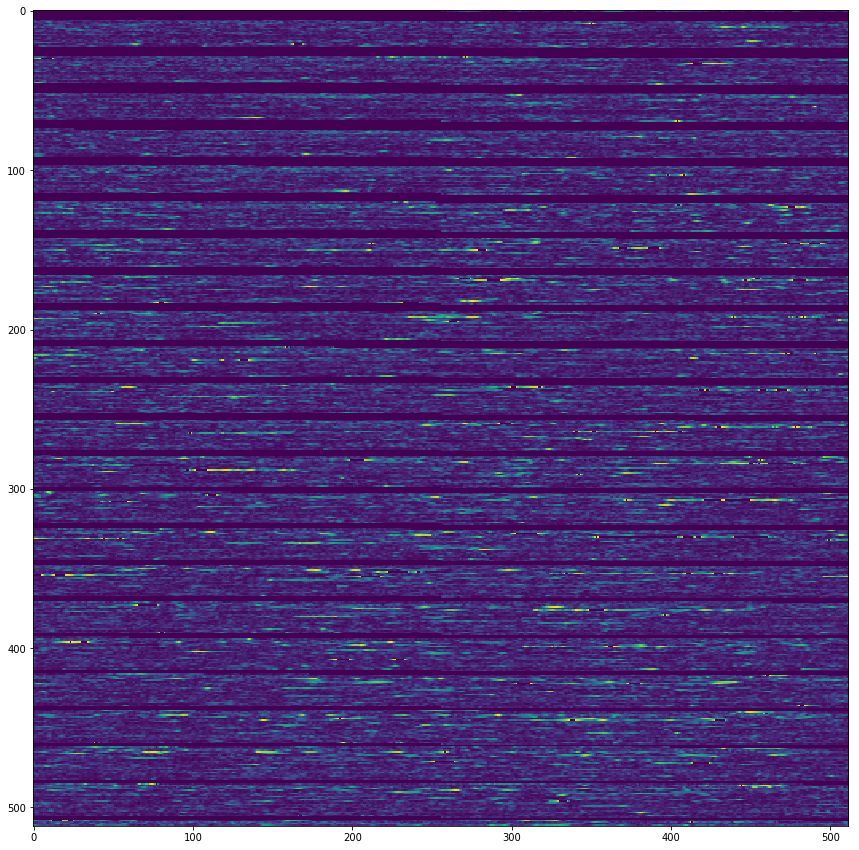

In [137]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(arr_split[0, :, :])

### validation data

In [9]:
t0 = time.time()
dict_paths_val = ld.paths_in_dict(path_data_local_val)

file_hfd5_val_X = join(dir_temp_val, 'Sou_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_Y = join(dir_temp_val, 'Sou_20191223_Y_{}.hdf5'.format(patch_size[0]))

pp.preprocces_data(dict_paths_val, file_hfd5_val_X, quantile_clip_max, patch_size, dtype, dir_temp_plots,
                   apply_log=True, a_l=a_l, b_l=b_l)
pp.preprocess_shape(dict_paths_val, file_hfd5_val_Y, patch_size, dtype_labels)

print('takes {} mins'.format(round((time.time() - t0)/60)))

Souleimaniye
  winter vh
 shape init (11264, 11264, 8)
  winter vv
  spring vh
  spring vv
  summer vh
  summer vv
  autumn vh
  autumn vv
shape dataset: (11264, 11264, 8)
Souleimaniye
polygon mask shape: (10979, 10980)
sum polygon_mask_int: 1861770

takes 4 mins


#### check result

In [ ]:
with h5py.File(file_hfd5_val_Y, 'r') as f_Y:
    print(f_Y.keys())

In [ ]:
with h5py.File(file_hfd5_val_X, 'r') as f_X:
    dataset_X  = f_X['Souleimaniye']
    X = dataset_X[:,:,0]
    print('dataset_X shape:', dataset_X.shape)

In [ ]:
# check 
with h5py.File(file_hfd5_val_Y, 'r') as f_Y:
    dataset_Y  = f_Y['Souleimaniye']
    labels = dataset_Y[:]
    print('labels shape:', labels.shape)

print(np.min(labels), np.max(labels), np.median(labels), np.mean(labels))
fig, ax = plt.subplots(figsize=(12,12))
ax.contour(labels, 1, colors='r')
ax.imshow(X)
#ax.imshow(labels)



In [ ]:
#large
fig, ax = plt.subplots(figsize=(150, 150))
#ax.imshow(polygon_mask, cmap='pink')
ax.contour(labels, 1, colors='red', linewidths=0.5)
ax.imshow(X)
fig.savefig(join(dir_temp_val, 'file_hfd5_val_X_{}.png'.format('Souleimaniye')))

### Test data

In [ ]:
t0 = time.time()
dict_paths_test = ld.paths_in_dict(path_data_local_test)

file_hfd5_test_X = join(dir_temp_test, 'MosNajNaS_20191220_X_{}.hdf5'.format(size_sub_sample[0]))
file_hfd5_test_Y = join(dir_temp_test, 'MosNajNaS_20191220_Y_{}.hdf5'.format(size_sub_sample[0]))

pp.preprocces_data(dict_paths_test, file_hfd5_test_X, quantile_clip_max, patch_size, dtype, dir_temp_plots)
pp.preprocess_shape(dict_paths_test, file_hfd5_test_Y, patch_size)

print('takes {} mins'.format(round((time.time() - t0)/60)))

## prepare data for network

Images and labels are in .npy / .h5 file shape now, but they need to be converted to suitable input for a network.
Therefore a full image is cut into many sub-samples of size 'size_sub_sample', e.g. (512, 512). This requires first zero padding (func zero_padding_1) in order to fit the image to an integer times size_sub_sample. <br>
Then we augment data by using a stride of size_sub_sample/inv_stride, i.e. we shift the image by for example half a sample size (inv_stride=2). Subsequently we cut into sub-images.  This results in inv_stride<sup>2</sup> times more data. In order to fit n sub-samples into a shifted image, new padding is required (func zero_padding_2). <br>
Output is saved in sub dir 'split'.

### develop (don't run for pipeline)

#### HDF5

In [ ]:
# def get_all(name):
#     print(name)

# def get_shape(ds):
#     print(ds.shape)
    
# with h5py.File(path_hd5, 'r') as f:
#     for key in f.keys():
#         ds = f[key]
#         print(ds.shape)

In [74]:
def zero_padding_2(arr, dim_str, inv_stride, patch_size):
    """ padding array to fit stride
    """
    if dim_str:
        if 'x' in dim_str:
            dim_x_add = int(np.ceil(patch_size[0] / inv_stride))
            arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=0)
            arr = np.concatenate((arr_zeros_stack, arr), axis=0)
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(patch_size[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)
    return arr


In [53]:
def split_array_2D(array, nrows, ncols):
    """Split a matrix into sub-matrices of shape (nrows, ncols)"""
    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                                     .swapaxes(1, 2)
                                     .reshape(-1, nrows, ncols))
    arr_4D_resh1 = np.array(list_3D_arrs)
    return arr_4D_resh1.reshape(arr_4D_resh1.shape[1], arr_4D_resh1.shape[0], 
                                arr_4D_resh1.shape[2], arr_4D_resh1.shape[3])

def list_stride(mode):
    if mode == 0:
        return ['_']
    if mode == 1:
        return ['_', 'x', 'y', 'xy']

In [ ]:
# test
test_arr = np.array([1,1])

with h5py.File('test.hdf5', 'w') as f:
    g = f.create_group('Base_Group')
    d = g.create_dataset('default', data=test_arr)

    metadata = {'Date': time.time()}

    f.attrs.update(metadata)

    for m in f.attrs.keys():
        print('{} => {}'.format(m, f.attrs[m]))

In [72]:
size_sub_sample = (512,512)
def prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img=8):
    t0 = time.time()
    with h5py.File(file_split_hfd5, 'w') as f2:
        with h5py.File(file_hfd5, 'r') as f1:

            idx_i = 0
            meta_data = dict()

            for area in sorted(f1.keys()):
                print(area)
                dset = f1[area]
                print(dset.shape)

                for dim_str in list_stride(stride_mode):
                    print("dim_str:", dim_str)
                    np_arr_shape = list(dset.shape)
                    if 'x' in dim_str:
                        np_arr_shape[0] = np_arr_shape[0] + size_sub_sample[0]
                    if 'y' in dim_str:
                        np_arr_shape[1] = np_arr_shape[1] + size_sub_sample[1]

                    idx_j = int(np_arr_shape[0] * np_arr_shape[1] / (size_sub_sample[0] * size_sub_sample[1])) + idx_i

                    if dataset_kind == 'labels':
                        np_arr_shape_split = (idx_j,) + size_sub_sample
                        maxshape = (None,) + size_sub_sample
                    elif dataset_kind == 'data':
                        np_arr_shape_split = (idx_j,) + size_sub_sample + (depth_img,)
                        maxshape = (None,) + size_sub_sample + (depth_img,)

                    if idx_i == 0:
                        dset2 = f2.create_dataset(name_dset, 
                                                    np_arr_shape_split,
                                                    compression="gzip",
                                                    compression_opts=4
                                                    dtype=np.uint16,
                                                    maxshape=maxshape,
                                                    chunks=True)

                    if dataset_kind == 'labels':
                        dset2.resize((idx_j,) + size_sub_sample)
                        dset2[idx_i:idx_j,:,:] = split_array_2D(zero_padding_2(dset[:], 
                                                                           dim_str,
                                                                           inv_stride, 
                                                                           size_sub_sample), 
                                                                size_sub_sample[0], 
                                                                size_sub_sample[1])
                    elif dataset_kind == 'data':
                        dset2.resize((idx_j,) + size_sub_sample + (depth_img,))
                        for k in range(depth_img):
                            X = split_array_2D(zero_padding_2(dset[:,:,k], 
                                                                           dim_str,
                                                                           inv_stride, 
                                                                           size_sub_sample), 
                                                                        size_sub_sample[0], 
                                                                        size_sub_sample[1])
                            print(X.shape)
                            if k == 0:
                                fig, ax = plt.subplots(figsize=(15,15))
                                ax.imshow(X[300,:,:])
                                fig.savefig(join(dir_temp_plots, dim_str + '.png'))
                                plt.close()
        
                            dset2[idx_i:idx_j,:,:,k] =X*2**16
            
                    print("dset2.shape:", dset2.shape)
                    print('idx i,j:', idx_i, idx_j)
                    meta_data[area + ' ' + dim_str] = (idx_i, idx_j)
                    idx_i = idx_j

                f2.attrs.update(meta_data)

    print('takes {} mins'.format(round((time.time() - t0) / 60)))
    

In [73]:
file_hfd5 =  join(dir_temp_train,  'MosNajNaS_20191222_X_512.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'MosNajNaS_20191222_X_512.hdf5')
depth_img = 8
stride_mode = 1
name_dset = 'all_train_data_X'
dataset_kind = 'data'


prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind, depth_img)

Mosul
(11264, 11264, 8)
dim_str: _
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
(484, 512, 512)
dset2.shape: (484, 512, 512, 8)
idx i,j: 0 484
dim_str: x
(506, 512, 512)
(506, 512, 512)


KeyboardInterrupt: 

In [ ]:
file_hfd5 =  join(dir_temp_dev,  'testrun_Y.hdf5')
file_split_hfd5 = join(dir_temp_dev,  'testrun_Y_split.hdf5')
stride_mode = 1
name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


prepare_data_for_nn_pipeline(file_hfd5, file_split_hfd5, stride_mode, name_dset, dataset_kind)

In [ ]:
# t0 = time.time()

# file_hfd5_labels_split =  join(dir_temp_dev,  'testrun_Y_split.hdf5')

# name_dset = 'all_train_data_Y'

# with h5py.File(file_hfd5_labels_split, 'w') as f2:
#     with h5py.File(file_hfd5_labels, 'r') as f1:
#         idx_i = 0
#         meta_data = dict()
        
#         for area in f1.keys():
#             print(area)
#             dset = f1[area]
#             print(dset.shape)

#             for dim_str in ['_', 'x', 'y', 'xy']:
#                 print("dim_str:", dim_str)
#                 np_arr_shape = list(dset.shape)
#                 if 'x' in dim_str:
#                     np_arr_shape[0] = np_arr_shape[0] + size_sub_sample[0]
#                 if 'y' in dim_str:
#                     np_arr_shape[1] = np_arr_shape[1] + size_sub_sample[1]
                
#                 idx_j = int(np_arr_shape[0] * np_arr_shape[1] / (size_sub_sample[0] * size_sub_sample[1])) + idx_i
#                 np_arr_shape_split = (idx_j,) + size_sub_sample
                
#                 if idx_i == 0:
#                     dset2 = f2.create_dataset(name_dset, 
#                                                 np_arr_shape_split,
#                                                 dtype=dtype,
#                                                 chunks=True)
                
#                 print("dset2.shape:", dset2.shape)

#                 dset2[idx_i:idx_j,:,:] = split_array_2D(zero_padding_2(dset[:], 
#                                                                        dim_str,
#                                                                        inv_stride, 
#                                                                        size_sub_sample), 
#                                                         size_sub_sample[0], 
#                                                         size_sub_sample[1])
                
                
#                 print('idx i,j:', idx_i, idx_j)
#                 meta_data[area + ' ' + dim_str] = (idx_i, idx_j)
#                 idx_i = idx_j

#             f2.attrs.update(meta_data)
#             print("shape dataset:", dset2.shape)

# print("total time:", time.time() - t0)

In [ ]:
#TODO: in a different separate step, concatenate datasets of areas
# see: https://stackoverflow.com/questions/43929420/how-to-concatenate-two-numpy-arrays-in-hdf5-format

# same for labels

#### numpy

In [ ]:
dir_label_dev = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/data_temp/train/labels'
area_file_label_dev = 'Mosul_label.npy'
arr_label_dev = np.load(join(dir_label_dev, 'whole', area_file_label_dev))

In [ ]:
print(arr.shape)
dim_x = arr.shape[1]
dim_x_add = size_sub_sample[0] - dim_x % size_sub_sample[0]
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)

In [ ]:
dim_y = arr.shape[2]
dim_y_add = size_sub_sample[1] - dim_y % size_sub_sample[1]
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
print("new size padding 1:", arr.shape)

In [ ]:
print('x1:', arr.shape)
dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]),  dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=1)
arr = np.concatenate((arr_zeros_stack, arr), axis=1)
print('x2:', arr.shape)

dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add),  dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
arr = np.concatenate((arr_zeros_stack, arr), axis=2)

sys.getsizeof(arr) / 10**9, arr.shape

In [ ]:
def zero_padding_1(arr, sub_sample_shape):
    """make array dimension a multiple of sub_sample_shape
    """
    print(arr.shape)
    dim_x = arr.shape[1]
    dim_x_add = sub_sample_shape[0] - dim_x % sub_sample_shape[0]
    arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=1)

    dim_y = arr.shape[2]
    dim_y_add = sub_sample_shape[1] - dim_y % sub_sample_shape[1]
    arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=2)
    print("new size padding 1:", arr.shape)

    return arr


    dim_x_add = size_sub_sample[0] - shape_x % size_sub_sample[0]
    dim_y_add = size_sub_sample[1] - shape_y % size_sub_sample[1]
    
def pad_zeros_xy(arr, dim_x_add, dim_y_add, both_sides=False):
    arr_zeros_stack_x = np.zeros((dim_x_add, shape_y), dtype=np.uint8)
    arr = np.concatenate((arr, arr_zeros_stack_x), axis=0)

    if both_sides:
        arr = np.concatenate((arr_zeros_stack_x, arr), axis=0)
        
    arr_zeros_stack_y = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint8)
    arr =  np.concatenate((arr, arr_zeros_stack_y), axis=1)
    
    if both_sides:
        arr =  np.concatenate((arr_zeros_stack_y, arr), axis=1)
        
    return arr


def zero_padding_2(arr, dim_str, inv_stride, size_sub_sample):
    """ padding array to fit stride
    """
    print('padding 2:')
    print(' dim_str:', dim_str)
    if dim_str:
        if 'x' in dim_str:
            print('x1:', arr.shape)
            dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)
            print('x2:', arr.shape)
        
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add),
                                       dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=2)
            arr = np.concatenate((arr_zeros_stack, arr), axis=2)

    print(" new size array:", arr.shape)
    return arr

def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                                     .swapaxes(1, 2)
                                     .reshape(-1, nrows, ncols))
    arr_4D_resh1 = np.array(list_3D_arrs)
    return arr_4D_resh1.reshape(arr_4D_resh1.shape[1], arr_4D_resh1.shape[0], 
                                arr_4D_resh1.shape[2], arr_4D_resh1.shape[3])

def save_array_in_new_sub_dir(arr, main_dir, name_new_dir, filename, dim_str):
    print('save_array_in_new_sub_dir')
    name_new_dir = 'split'
    dir_data_split = join(main_dir, name_new_dir) 
    ld.make_dir(dir_data_split)
    path_file_split = join(dir_data_split, os.path.splitext(filename)[0] + '_' + name_new_dir + '_' + dim_str)
    np.save(path_file_split, arr)
    del arr
    gc.collect()
    
    

            

In [ ]:
def split_array_2D(array, nrows, ncols):
    """Split a matrix into sub-matrices and ."""
    r, h = array.shape
    arr_3D = array.reshape(h//nrows, nrows, -1, ncols).swapaxes(1, 2).reshape(-1, nrows, ncols)
    return [arr for arr in arr_3D]


def split_array_3D(array, nrows, ncols):
    """Split a 3D array into sub-arrays."""
    w, r, h = array.shape
    list_3D_arrs = []
        
    for i in range(w):
        arr_2D = array[i, :, :]

        list_3D_arrs.append(arr_2D.reshape(h//nrows, nrows, -1, ncols)
                             .swapaxes(1, 2)
                             .reshape(-1, nrows, ncols))
    
        arr_4D = np.array(list_3D_arrs)
        
    arr_4D = arr_4D.reshape(arr_4D.shape[1], arr_4D.shape[0], arr_4D.shape[2], arr_4D.shape[3])
    return [arr for arr in arr_4D]

def save_samples(list_arrs, main_dir, name_new_dir, filename, dim_str):
    print('  save samples')
    dir_data_split = join(main_dir, name_new_dir)
    ld.make_dir(dir_data_split)

    str_filename =  os.path.splitext(filename)[0] + '_' + name_new_dir + '_' + dim_str + '_{}' 
    for i, arr in enumerate(list_arrs):
        path_file_split = join(dir_data_split, str_filename.format(i))
        np.save(path_file_split, arr)
    del arr
    gc.collect()

    
def zero_padding_1_labels(arr, sub_sample_shape):
    """make array dimension a multiple of sub_sample_shape
    """
    print('  padding 1')
    dim_x = arr.shape[0]
    dim_x_add = sub_sample_shape[0] - dim_x % sub_sample_shape[0]
    arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=0)

    dim_y = arr.shape[1]
    dim_y_add = sub_sample_shape[1] - dim_y % sub_sample_shape[1]
    arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint16)
    arr = np.concatenate((arr, arr_zeros_stack), axis=1)
    print("   new size padding 1:", arr.shape)

    return arr

def zero_padding_2_labels(arr, dim_str, inv_stride, size_sub_sample):
    """ padding array to fit stride
    """
    print('  padding 2:')
    print('    dim_str:', dim_str)
    if dim_str:
        if 'x' in dim_str:
            dim_x_add = int(np.ceil(size_sub_sample[0] / inv_stride))
            arr_zeros_stack = np.zeros((dim_x_add, arr.shape[1]), dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=0)
            arr = np.concatenate((arr_zeros_stack, arr), axis=0)
        
        if 'y' in dim_str:
            dim_y_add = int(np.ceil(size_sub_sample[1] / inv_stride))
            arr_zeros_stack = np.zeros((arr.shape[0], dim_y_add), dtype=np.uint16)
            arr = np.concatenate((arr, arr_zeros_stack), axis=1)
            arr = np.concatenate((arr_zeros_stack, arr), axis=1)

    print("   new size array:", arr.shape)
    return arr

In [ ]:
# zero padding 1
dim_x = arr.shape[1]
dim_x_add = size_sub_sample[0] - dim_x % size_sub_sample[0]
arr_zeros_stack = np.zeros((arr.shape[0], dim_x_add, arr.shape[2]), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=1)

dim_y = arr.shape[2]
dim_y_add = size_sub_sample[1] - dim_y % size_sub_sample[1]
arr_zeros_stack = np.zeros((arr.shape[0], arr.shape[1], dim_y_add), dtype=np.uint16)
arr = np.concatenate((arr, arr_zeros_stack), axis=2)
print("new size padding 1:", arr.shape)

In [ ]:
# rest of pipeline
for dim_str in ['', 'x', 'y', 'xy']:
    #zero padding 2
    arr_area_2 = zero_padding_2(arr, dim_str, inv_stride, size_sub_sample)
    print('pad 2',sys.getsizeof(arr_area_2) / 10**9, arr_area_2.shape)

    #split
    list_arrs = split_array_3D(arr_area_2, size_sub_sample[0], size_sub_sample[1])
    print('len list:', len(list_arrs))
    print('shape arr:', list_arrs[0].shape)
    del arr_area_2
    gc.collect()
    
    save_samples(list_arrs, dir_data_dev, 'split', area_file_dev, dim_str)
    del list_arrs
    gc.collect()
    
del arr
gc.collect()



In [ ]:
arr_label_dev = zero_padding_1_labels(arr_label_dev, size_sub_sample)


for dim_str in ['', 'x', 'y', 'xy']:
    arr_area_2 = zero_padding_2_labels(arr_label_dev, dim_str, inv_stride, size_sub_sample)
    list_arrs = split_array_2D(arr_area_2, size_sub_sample[0], size_sub_sample[1])
    del arr_area_2
    gc.collect()
    print('len list:', len(list_arrs))
    save_samples(list_arrs, dir_label_dev, 'split', area_file_label_dev, dim_str)
    del list_arrs
    gc.collect()
del arr_area
gc.collect()

### pipeline

#### training

In [129]:
file_hfd5_train_X = join(dir_temp_train, 'MosNajNaS_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_X_patches = join(dir_temp_train,  'MosNajNaS_20191224_X_{}_patches.hdf5'.format(patch_size[0]))

depth_img = 8
stride_mode = [1,4][1] 
name_dset = 'all_train_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5_train_X,
                                 file_hfd5_train_X_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind,
                                 depth_img)

Mosul
(11264, 11264, 8)
dim_str: _
dset2.shape: (484, 512, 512, 8)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512, 8)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512, 8)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512, 8)
idx i,j: 1496 2025
Najaf
(11264, 11264, 8)
dim_str: _
dset2.shape: (2509, 512, 512, 8)
idx i,j: 2025 2509
dim_str: x
dset2.shape: (3015, 512, 512, 8)
idx i,j: 2509 3015
dim_str: y
dset2.shape: (3521, 512, 512, 8)
idx i,j: 3015 3521
dim_str: xy
dset2.shape: (4050, 512, 512, 8)
idx i,j: 3521 4050
Nasiryah
(11264, 11264, 8)
dim_str: _
dset2.shape: (4534, 512, 512, 8)
idx i,j: 4050 4534
dim_str: x
dset2.shape: (5040, 512, 512, 8)
idx i,j: 4534 5040
dim_str: y
dset2.shape: (5546, 512, 512, 8)
idx i,j: 5040 5546
dim_str: xy
dset2.shape: (6075, 512, 512, 8)
idx i,j: 5546 6075
takes 99 mins


In [130]:
file_hfd5_train_Y = join(dir_temp_train, 'MosNajNaS_20191223_Y_{}.hdf5'.format(patch_size[0]))
file_hfd5_train_Y_patches = join(dir_temp_train, 'MosNajNaS_20191224_Y_{}_patches.hdf5'.format(patch_size[0]))
stride_mode = [1,4][1]  # 1
name_dset = 'all_train_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_hfd5_train_Y, 
                                 file_hfd5_train_Y_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind)

Mosul
(11264, 11264)
dim_str: _
dset2.shape: (484, 512, 512)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512)
idx i,j: 1496 2025
Najaf
(11264, 11264)
dim_str: _
dset2.shape: (2509, 512, 512)
idx i,j: 2025 2509
dim_str: x
dset2.shape: (3015, 512, 512)
idx i,j: 2509 3015
dim_str: y
dset2.shape: (3521, 512, 512)
idx i,j: 3015 3521
dim_str: xy
dset2.shape: (4050, 512, 512)
idx i,j: 3521 4050
Nasiryah
(11264, 11264)
dim_str: _
dset2.shape: (4534, 512, 512)
idx i,j: 4050 4534
dim_str: x
dset2.shape: (5040, 512, 512)
idx i,j: 4534 5040
dim_str: y
dset2.shape: (5546, 512, 512)
idx i,j: 5040 5546
dim_str: xy
dset2.shape: (6075, 512, 512)
idx i,j: 5546 6075
takes 1 mins


#### check results  training

In [79]:
with h5py.File(file_hfd5_train_X_patches, 'r') as f_Y:
    print(f_Y.keys())

<KeysViewHDF5 ['all_train_data_X']>


In [93]:
patch_k = 4410
layer_n = 7
with h5py.File(file_hfd5_train_X_patches, 'r') as f_X:
    dataset_X  = f_X['all_train_data_X']
    print('dataset_X shape:', dataset_X.shape)
    X = dataset_X[patch_k, :,:,layer_n]
    print('X.shape', X.shape)

print('X values:', np.min(X), np.max(X), np.median(X).astype(np.uint16), np.mean(X))

dataset_X shape: (6075, 512, 512, 8)
X.shape (512, 512)
X values: 0 65446 18151 19424.664722442627


In [81]:
# check 
with h5py.File(file_hfd5_train_Y_patches, 'r') as f_Y:
    dataset_Y  = f_Y['all_train_data_Y']
    print(dataset_Y.shape)
    labels = dataset_Y[patch_k,:, :]
    print('labels shape:', labels.shape)

(6075, 512, 512)
labels shape: (512, 512)


0 1 0.0 0.097625732421875


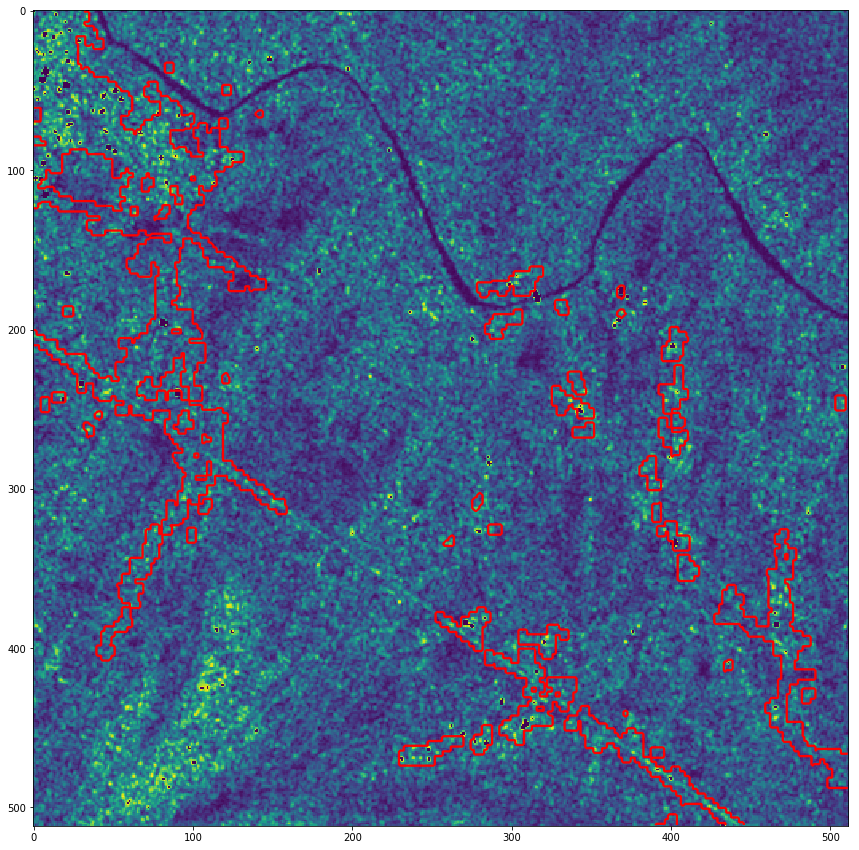

In [82]:
print('label values:', np.min(labels), np.max(labels), np.median(labels), np.mean(labels))
fig, ax = plt.subplots(figsize=(15,15))
ax.contour(labels, 1, colors='r')
ax.imshow(X)
#ax.imshow(labels)

#### validation

In [131]:
file_hfd5_val_X = join(dir_temp_val, 'Sou_20191223_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_X_patches = join(dir_temp_val,  'Sou_20191224_X_{}_patches.hdf5'.format(patch_size[0]))

depth_img = 8
stride_mode = [1,4][1] 
name_dset = 'all_val_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5_val_X,
                                 file_hfd5_val_X_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind,
                                 depth_img)

Souleimaniye
(11264, 11264, 8)
dim_str: _
dset2.shape: (484, 512, 512, 8)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512, 8)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512, 8)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512, 8)
idx i,j: 1496 2025
takes 31 mins


In [132]:
file_hfd5_val_Y = join(dir_temp_val, 'Sou_20191223_Y_{}.hdf5'.format(patch_size[0]))
file_hfd5_val_Y_patches = join(dir_temp_val, 'Sou_20191224_Y_{}_patches.hdf5'.format(patch_size[0]))
stride_mode = [1,4][1]  # 1
name_dset = 'all_val_data_Y'
dataset_kind = 'labels'


pfn.prepare_data_for_nn_pipeline(file_hfd5_val_Y, 
                                 file_hfd5_val_Y_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind)

Souleimaniye
(11264, 11264)
dim_str: _
dset2.shape: (484, 512, 512)
idx i,j: 0 484
dim_str: x
dset2.shape: (990, 512, 512)
idx i,j: 484 990
dim_str: y
dset2.shape: (1496, 512, 512)
idx i,j: 990 1496
dim_str: xy
dset2.shape: (2025, 512, 512)
idx i,j: 1496 2025
takes 0 mins


#### check results Validation

In [94]:
with h5py.File(file_hfd5_val_X_patches, 'r') as f_Y:
    print(f_Y.keys())

<KeysViewHDF5 ['all_val_data_X']>


In [95]:
patch_k = 200
layer_n = 0
with h5py.File(file_hfd5_val_X_patches, 'r') as f_X:
    dataset_X  = f_X['all_val_data_X']
    X = dataset_X[patch_k,:,:,layer_n]
    print('dataset_X shape:', dataset_X.shape)
print('shape X', X.shape)
print('X values:', np.min(X), np.max(X), np.median(X).astype(np.uint16), np.mean(X))

dataset_X shape: (2025, 512, 512, 8)
shape X (512, 512)
X values: 0 65346 5773 6774.069751739502


In [68]:
# check 
with h5py.File(file_hfd5_val_Y_patches, 'r') as f_Y:
    dataset_Y  = f_Y['all_val_data_Y']
    labels = dataset_Y[patch_k, :, :]
    print('labels shape:', labels.shape)


labels shape: (512, 512)


0 1 0.0 0.052608489990234375


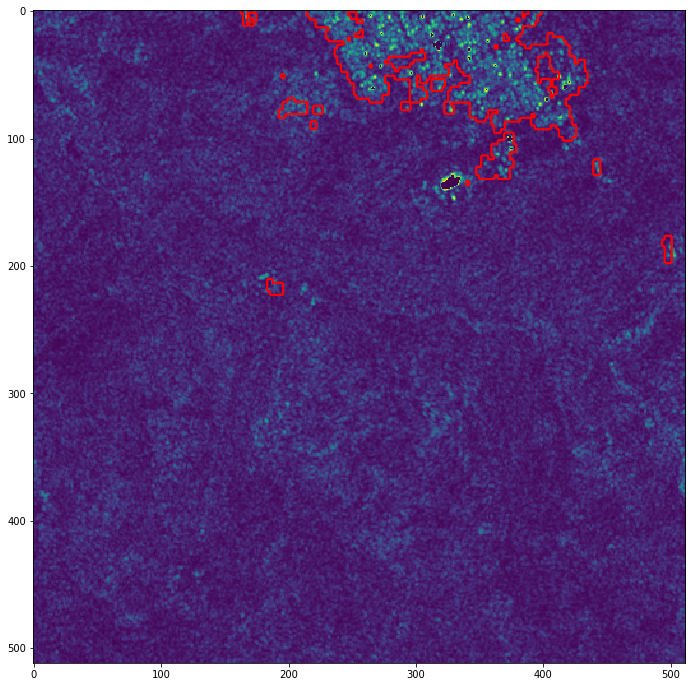

In [69]:
print(np.min(labels), np.max(labels), np.median(labels), np.mean(labels))
fig, ax = plt.subplots(figsize=(12,12))
ax.contour(labels, 1, colors='r')
ax.imshow(X)
#ax.imshow(labels)

#### Test

In [ ]:
file_hfd5_eval_X = join(dir_temp_train, 'Bag_20191222_X_{}.hdf5'.format(patch_size[0]))
file_hfd5_eval_X_patches = join(dir_temp_dev,  'Bag_20191222_X_{}_patches.hdf5'.format(patch_size[0]))

depth_img = 8
stride_mode = [1,4][1] 
name_dset = 'all_val_data_X'
dataset_kind = 'data'

pfn.prepare_data_for_nn_pipeline(file_hfd5_eval_X,
                                 file_hfd5_eval_X_patches,
                                 patch_size,
                                 stride_mode, 
                                 name_dset,
                                 dtype,
                                 inv_stride,
                                 dataset_kind,
                                 depth_img)

### convert dset

In [128]:
name_dset_train_X = 'all_train_data_X'
dataset_kind_train_X = 'data'
name_dset_train_Y = 'all_train_data_Y'
dataset_kind_train_Y = 'labels'

file_hfd5_train_X_patches = '/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/data_temp/train/MosNajNaS_20191223_X_512_patches.hdf5'
#file_hfd5_train_X_patches_large = file_hfd5_train_X_patches = join(dir_temp_train,  'MosNajNaS_20191224_X_{}_patches.hdf5'.format(patch_size[0]))

file_hfd5_train_X_patches_large = join(dir_temp_train,  'test_convert.hdf5'.format(patch_size[0]))

with h5py.File(file_hfd5_train_X_patches, 'r') as f1_X:
    print(f1_X.keys())
#     dataset_X = f1_X[name_dset_train_X]

#     with h5py.File(file_hfd5_train_X_patches_large, 'w') as f2:
#         f2[name_dset_train_X] = f1_X.astype(np.float32)

<KeysViewHDF5 []>


## Deep learning

### develop (don't run for pipeline)

#### HDF5

In [ ]:
class My_Custom_Generator(Sequence):
    def __init__(self, file_hdf5_X, file_hdf5_Y, batch_size):
        self.file_hdf5_X = file_hdf5_X
        self.file_hdf5_Y = file_hdf5_Y
        self.batch_size = batch_size
     
    def __len__(self) :
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            len_dataset_Y = dataset_Y.shape[0]
        
        return (np.ceil(len_dataset_Y) / float(self.batch_size)).astype(np.int)
    
    def __getitem__(self, idx):
        with h5py.File(self.file_hdf5_X, 'r') as f1_X:
            dataset_X  = f1_X['all_train_data_X']
            batch_x = dataset_X[idx * self.batch_size : (idx+1) * self.batch_size, :, :, :]
        
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y['all_train_data_Y']
            batch_y = dataset_Y[idx * self.batch_size : (idx+1) * self.batch_size, :, :]

        return (batch_x, batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1))

In [ ]:
file_hdf5_X = join(dir_temp_dev,  'testrun_X_split.hdf5')
file_hdf5_Y = join(dir_temp_dev,  'testrun_Y_split.hdf5')

In [ ]:
my_training_batch_gen = My_Custom_Generator(file_hdf5_X, file_hdf5_Y, BS)

In [ ]:
for i, arr in enumerate(my_training_batch_gen):
    print(arr[0].shape, arr[1].shape)
    if i>3:
        break

In [ ]:
my_training_batch_gen.__len__(), len(my_training_batch_gen)

In [ ]:
with h5py.File(file_hdf5_X, 'r') as f1_Y:
    dataset_Y  = f1_Y['all_train_data_X']
    print(dataset_Y.shape)
    

In [ ]:
model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  # metrics=["accuracy"],
                  metrics=[iou, iou_thresholded])

In [ ]:
H = model.fit(dataset_X, dataset_Y,  
                 batch_size=BS, 
                epochs=EPOCHS, 
                verbose=1)

### load data dev

In [ ]:
file_hdf5_X = join(dir_temp_dev,  'testrun_X_split.hdf5')
file_hdf5_Y = join(dir_temp_dev,  'testrun_Y_split.hdf5')

In [ ]:
with h5py.File(file_hdf5_Y, 'r') as f1_Y:
    dsety  = f1_Y['all_train_data_Y']
    dataset_Y = dsety[:100]
    
dataset_Y = dataset_Y.reshape(dataset_Y.shape[0], dataset_Y.shape[1], dataset_Y.shape[2], 1)#.copy()

with h5py.File(file_hdf5_X, 'r') as f1_X:
    dsetx = f1_X['all_train_data_X']
    dataset_X = dsetx[:100]

In [ ]:
dataset_Y.shape, dataset_X.shape

In [ ]:
dataset_X_1 = dataset_X[:,:,:,0:1]#.copy()

In [ ]:
np.sum(dataset_X_1), np.sum(dataset_Y)

In [ ]:
dataset_Y.shape, dataset_X_1.shape

In [ ]:
sys.getsizeof(dataset_X_1) / 10**9, sys.getsizeof(dataset_Y) / 10**9

In [ ]:
BS

In [ ]:
train_datagen_aug = get_augmented(
        dataset_X,
        dataset_Y.reshape(dataset_Y.shape[0], dataset_Y.shape[1], dataset_Y.shape[2], 1),
        X_val=None,
        Y_val=None,
        batch_size=BS,
        seed=0,
        data_gen_args=dict(
            rotation_range=90,
            height_shift_range=0,
            shear_range=0,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='constant'
        )
    )

#### numpy

In [ ]:
dir_train_X_split = join(dir_temp_train_X, 'split')
dir_train_Y_split = join(dir_temp_train_Y, 'split')

dir_val_X_split = join(dir_temp_val_X, 'split')
dir_val_Y_split = join(dir_temp_val_Y, 'split')

dir_test_X_split = join(dir_temp_test_X, 'split')

In [ ]:
class My_Custom_Generator(Sequence):
    def __init__(self, dir_X, dir_Y, batch_size):
        self.list_files_X = [join(dir_X, file_name) for file_name in os.listdir(dir_X)]
        self.list_files_Y = [join(dir_Y, file_name) for file_name in os.listdir(dir_Y)]
        self.batch_size = batch_size
     
    def __len__(self) :
        return (np.ceil(len(self.list_files_X) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        batch_x_in = self.list_files_X[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y_in = self.list_files_Y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        b_x = np.array([np.load(file_name) for file_name in batch_x_in if os.path.splitext(file_name)[1] == '.npy'])
        b_y = np.array([np.load(file_name) for file_name in batch_y_in if os.path.splitext(file_name)[1] == '.npy'])
        
        return (b_x.reshape(b_x.shape[0], b_x.shape[2], b_x.shape[3], b_x.shape[1]), 
                b_y.reshape(b_y.shape[0], b_y.shape[1], b_y.shape[2], 1))


In [ ]:
my_training_batch_gen = My_Custom_Generator(dir_train_X_split, dir_train_Y_split, BS)
my_validation_batch_gen = My_Custom_Generator(dir_val_X_split, dir_val_Y_split, BS)

In [ ]:
my_training_batch_gen.__len__() * 32

In [ ]:
for i, arr in enumerate(my_training_batch_gen):
    print(arr[0].shape, arr[1].shape)
    if i>10:
        break

In [ ]:
# callbacks
filepath =join(path_model, "weights-improvement-{epoch:02d}-{iou:.2f}.hdf5")

cb_chk = keras_cb.ModelCheckpoint(filepath, monitor='iou', verbose=1, save_best_only=True, mode='max')
#cb_proglog = keras_cb.ProgbarLogger()
cb_es = keras_cb.EarlyStopping(patience=5)
#cb_tb = keras_cb.tensorboard_v1.TensorBoard(log_dir=join(path_model, 'logs'), histogram_freq=1, batch_size=BS, 
                                            #write_graph=True, write_grads=True, write_images=True, update_freq='epoch')
callbacks_list = [cb_chk, cb_es]

In [ ]:
model.compile(loss="binary_crossentropy",
                  optimizer=opt,
                  # metrics=["accuracy"],
                  metrics=[iou, iou_thresholded])

In [ ]:
len(my_training_batch_gen.list_files_X) // BS

In [ ]:
H = model.fit_generator(generator=my_training_batch_gen,
                        steps_per_epoch=len(my_training_batch_gen.list_files_X) // BS,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        verbose=2,
#                         validation_data = my_validation_batch_gen,
#                         validation_steps = len(my_validation_batch_gen.list_files_X) // BS
                        )

In [ ]:
model_json = model.to_json()
path_json_file = join(path_model, "model_{}.json".format(utl.datetime_now), "w") 
with open(path_json_file as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(join(path_model, "model_epochs_{}.h5".format(utl.datetime_now)))

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["iou"], label="train_iou")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/iou")
plt.legend(loc="lower left")
plt.savefig(join(path_model, "plot")

In [ ]:
# train_datagen = get_augmented(
#         trainX,
#         trainY,
#         X_val=None,
#         Y_val=None,
#         batch_size=BS,
#         seed=0,
#         data_gen_args=dict(
#             rotation_range=90,
#             height_shift_range=0,
#             shear_range=0,
#             horizontal_flip=True,
#             vertical_flip=True,
#             fill_mode='constant'
#         )
#     )

### pipeline

In [96]:
# params
BS = 2
EPOCHS = 4
size_sub_sample = (512, 512)
num_layers = 2

batches_per_epoch_test = 100
val_batches_per_epoch_test = 100

In [102]:
inv_stride = 2
INIT_LR = 1e-3
depth_img = 8

IMAGE_DIMS = size_sub_sample + (depth_img,)
model = satellite_unet(IMAGE_DIMS, num_layers=num_layers)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

print(IMAGE_DIMS)

(512, 512, 8)


In [103]:
class My_Custom_Generator(Sequence):
    def __init__(self, file_hdf5_X, file_hdf5_Y, batch_size, name_dset_X, name_dset_Y):
        self.file_hdf5_X = file_hdf5_X
        self.file_hdf5_Y = file_hdf5_Y
        self.batch_size = batch_size
        self.name_dset_X =name_dset_X
        self.name_dset_Y = name_dset_Y
    
    def __len__(self) :
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y[self.name_dset_Y]
            len_dataset_Y = dataset_Y.shape[0]
        
        return (np.ceil(len_dataset_Y) / float(self.batch_size)).astype(np.int)
    
    def __getitem__(self, idx):
        with h5py.File(self.file_hdf5_X, 'r') as f1_X:
            dataset_X  = f1_X[self.name_dset_X]
            batch_x = dataset_X[idx * self.batch_size : (idx+1) * self.batch_size, :, :, :]
        
        with h5py.File(self.file_hdf5_Y, 'r') as f1_Y:
            dataset_Y  = f1_Y[self.name_dset_Y]
            batch_y = dataset_Y[idx * self.batch_size : (idx+1) * self.batch_size, :, :]

        return (batch_x, batch_y.reshape(batch_y.shape[0], batch_y.shape[1], batch_y.shape[2], 1))

In [104]:
file_hdf5_train_X_nn = join(dir_temp_train,  'MosNajNaS_20191222_X_{}_patches.hdf5'.format(patch_size[0]))
file_hdf5_train_Y_nn = join(dir_temp_train,  'MosNajNaS_20191222_Y_{}_patches.hdf5'.format(patch_size[0]))

my_training_batch_gen = My_Custom_Generator(file_hdf5_train_X_nn, file_hdf5_train_Y_nn, BS, 
                                            'all_train_data_X', 'all_train_data_Y')


In [105]:
file_hdf5_val_X_nn = join(dir_temp_val,  'Sou_20191222_X_{}_patches.hdf5'.format(patch_size[0]))
file_hdf5_val_Y_nn = join(dir_temp_val,  'Sou_20191222_Y_{}_patches.hdf5'.format(patch_size[0]))

my_val_batch_gen = My_Custom_Generator(file_hdf5_val_X_nn, file_hdf5_val_Y_nn, BS, 
                                            'all_val_data_X', 'all_val_data_Y')

In [49]:
if True:
    for i, arr in enumerate(my_val_batch_gen):
        print(arr[0].shape, arr[1].shape)
        if i>1:
            break

    print(my_training_batch_gen.__len__(), len(my_training_batch_gen))

(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
(2, 512, 512, 8) (2, 512, 512, 1)
3037 3037


In [50]:
def get_init_epoch(filepath_chk):
    return int(filepath_chk.split('-')[2])

In [51]:
#checkpoints
filepath_chk = None
for i, file in enumerate(os.listdir(path_checkpoints)): 
    if i == len(os.listdir(path_checkpoints)) - 1:
        if file != '.DS_Store':
            filepath_chk = join(path_checkpoints, file)
            print('load checkpoint: {}'.format(filepath_chk))
            
            
if filepath_chk is not None:
    print('loading model..')
    model = load_model(filepath_chk, custom_objects={"iou": iou, "iou_thresholded":iou_thresholded})
    
    # Finding the epoch index from which we are resuming
    print('find epoch..')
    initial_epoch = get_init_epoch(filepath_chk)
    
#     # Calculating the correct value of count
#     count = initial_epoch*batches_per_epoch_test
#     # Update the value of count in callback instance
#     callbacks_list[1].count = count

 
    # update the learning rate
    #print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    #K.set_value(model.optimizer.lr, 1e-2)
    #print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))
    
    
else:
#   model = model_init
    filepath_chk = join(path_checkpoints, "weights-best-{epoch:02d}-{iou:.3f}.hdf5")
    initial_epoch = 0
    print('compile model...') 
    model.compile(loss="binary_crossentropy",
                      optimizer=opt,
                      #metrics=["accuracy"],
                      metrics=[iou, iou_thresholded]
                 )
    
print('use checkpoint file:', filepath_chk)
print('initial_epoch:', initial_epoch)

load checkpoint: /Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/model/checkpoints/weights-best-01-0.034.hdf5
loading model..
find epoch..
use checkpoint file: /Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/model/checkpoints/weights-best-01-0.034.hdf5
initial_epoch: 1


In [52]:
def save_yaml_hyperparms(path_save, dict_hyperparms):
    fn_yaml = 'hyperparms.yaml'
    with open(join(path_save, fn_yaml), 'w') as file:
        yaml.dump(dict_hyperparms, file)


In [56]:
# callbacks
cb_chk = keras_cb.ModelCheckpoint(filepath_chk, monitor='iou', verbose=1, save_best_only=True, 
                                  mode='max')
#cb_proglog = keras_cb.ProgbarLogger()
cb_es = keras_cb.EarlyStopping(patience=5)
cb_tb = keras_cb.TensorBoard(log_dir=join(path_model, 'tensorboard_logs'), histogram_freq=1, batch_size=BS, 
                                            write_graph=True, write_grads=True, write_images=True, 
                                            update_freq='epoch')
callbacks_list = [cb_chk, cb_es]# cb_tb]

In [54]:
H = model.fit_generator(generator=my_training_batch_gen,
                        steps_per_epoch=batches_per_epoch_test,
                        validation_data=my_val_batch_gen,
                        validation_steps=val_batches_per_epoch_test,
                        epochs=EPOCHS,
                        callbacks=callbacks_list,
                        verbose=1,
                        initial_epoch=initial_epoch
                        )

Epoch 2/4
10/10 [==============================] - 270s 27s/step - loss: 0.0591 - iou: 0.0291 - iou_thresholded: 0.2211 - val_loss: 0.0120 - val_iou: 2.9430e-04 - val_iou_thresholded: 0.9001

Epoch 00002: iou improved from -inf to 0.02908, saving model to /Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/model/checkpoints/weights-best-01-0.034.hdf5
Epoch 3/4
10/10 [==============================] - 223s 22s/step - loss: 0.0714 - iou: 0.0204 - iou_thresholded: 0.2097 - val_loss: 0.0239 - val_iou: 0.0017 - val_iou_thresholded: 0.5151

Epoch 00003: iou did not improve from 0.02908
Epoch 4/4
10/10 [==============================] - 227s 23s/step - loss: 0.0805 - iou: 0.0234 - iou_thresholded: 0.1047 - val_loss: 0.0320 - val_iou: 0.0118 - val_iou_thresholded: 0.3041

Epoch 00004: iou did not improve from 0.02908


In [ ]:
model_json = model.to_json()
path_json_file = join(path_model, "model_{}.json".format(utl.datetime_now()))
with open(path_json_file, 'w') as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(join(path_model, "model_epochs_{}.h5".format(utl.datetime_now())))

In [ ]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["iou"], label="train_iou")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/iou")
plt.legend(loc="lower left")
file_plot_train_info = join(path_model, 'info_train_{}.png'.format(utl.datetime_now()))
plt.savefig(file_plot_train_info)


## evaluation

### def

In [58]:
filepath_model =join(path_checkpoints, "best-weights-07-0.117.hdf5")

In [61]:
file_hdf5_val_X_nn

'/Volumes/other/datasets_and_ML/UNOSAT_Challenge/data/data_temp/val/Sou_20191222_X_512_patches.hdf5'

In [59]:
model = load_model(filepath_model, custom_objects={"iou": iou, "iou_thresholded":iou_thresholded})

labels shape: (512, 512)


In [104]:
with h5py.File(file_hfd5_val_Y_patches, 'r') as f_Y:
    for key in f_Y.keys():
        print(key)

all_val_data_Y


In [105]:
k_patch = 100
with h5py.File(file_hfd5_val_Y_patches, 'r') as f_Y:
    dataset_Y  = f_Y['all_val_data_Y']
    labels = dataset_Y[:,:,:]
    print('labels shape:', labels.shape)

print(np.min(labels), np.max(labels), np.median(labels), np.mean(labels))
# fig, ax = plt.subplots(figsize=(12,12))
# ax.contour(labels, 1, colors='r')
# ax.imshow(labels)

labels shape: (2025, 512, 512)
0 1 0.0 0.01402881763599537


In [99]:
np.min(labels), np.max(labels), np.median(labels), np.mean(labels)

(0, 0, 0.0, 0.0)

(512, 512, 8)
(2025, 512, 512, 8)
labels shape: (512, 512)
takes: 5.607727289199829 s


/Users/jurriaan/.local/lib/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


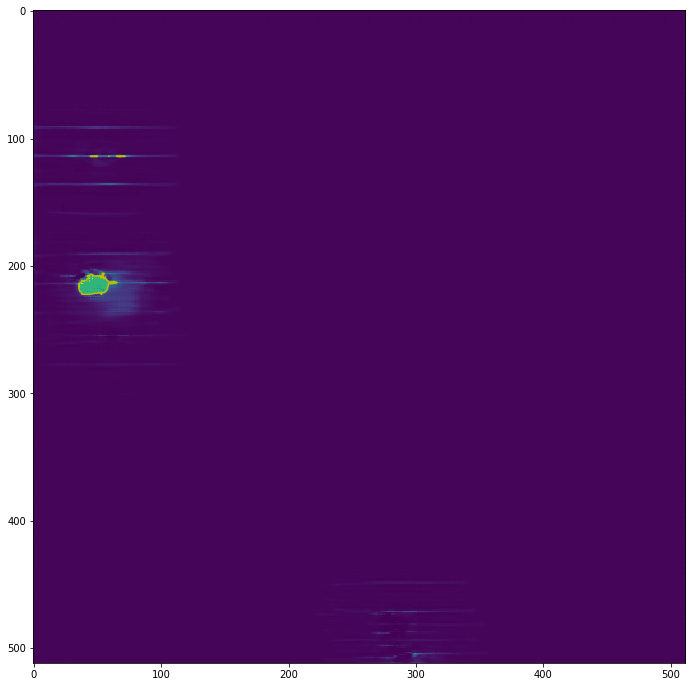

In [95]:
# test a single prediction
k_patch = 300 

t0 = time.time()
with h5py.File(file_hdf5_val_X_nn, 'r') as f_X:
    dataset_X  = f_X['all_val_data_X']
    patch_test = dataset_X[k_patch, :, :, :]
    print(patch_test.shape)
    
    ds_shp = dataset_X.shape
    print(ds_shp)
    prediction_test = model.predict(dataset_X[k_patch, :, :, :].reshape(1, ds_shp[1], ds_shp[2], ds_shp[3]))
    
with h5py.File(file_hdf5_val_Y_nn, 'r') as f_Y:
    dataset_Y  = f_Y['all_val_data_Y']
    labels = dataset_Y[k_patch,:,:]
    print('labels shape:', labels.shape)

    
print('takes:', time.time() - t0, 's')
arr_pred_test_resh = prediction_test.reshape(patch_size)

fig, ax = plt.subplots(figsize=(12,12))
n_levels = 1
ax.contour(arr_pred_test_resh, n_levels, colors='y')
ax.contour(labels, n_levels, colors='r') 
ax.imshow(arr_pred_test_resh)

In [78]:
np.min(arr_pred_test_resh), np.max(arr_pred_test_resh), np.median(arr_pred_test_resh), np.mean(arr_pred_test_resh)

(4.2408705e-05, 0.9920629, 0.022490948, 0.07496398)

In [ ]:
# predictions
area = 'Sou'
shape_x = 
shape_y = 

org_img_size = ...


s_x = size_sub_sample[0]
s_y = size_sub_sample[1]
stride_x = s_x
stride_y = s_

with h5py.File(file_val_predict_X, 'w') as f2_X:
    dset2 = f2_X.create_dataset('predict_{}'.format(area), 
                                (shape_x, shape_y),
                                dtype=dtype,
                                maxshape=maxshape,
                                chunks=True)
    
    with h5py.File(file_val_split_hfd5_X, 'r') as f1_X:
        dataset_X  = f1_X['all_val_data_X']
        #TODO: use metadata to split '_', 'x', 'y', 'xy'
        metadata = f1_X.metadata
        
        for dim_str in ['_', 'x', 'y', 'xy']:
            org_img_size = ...
            dataset_dim =...
        
            i_max = (org_img_size[0] // stride) + 1 - (size // stride)
            j_max = (org_img_size[1] // stride) + 1 - (size // stride)

            k = 0
            for i in range(i_max):
                for j in range(j_max):
                    dset2[i*stride_x : i*stride_x+s_x, j*stride_y : j*stride_y+s_y] = model.predict(dataset_dim[k, :, :, :])
                    k += 1       
 

In [ ]:
#TODO: zero unpadding

In [ ]:
with h5py.File(file_val_split_hfd5_Y, 'r') as f1_Y:
    dataset_Y  = f1_Y['all_val_data_Y']

In [14]:
def next_list(list_x):
    yield list_x
    


In [48]:
np.array([1.234]).astype(np.uint16)

array([1], dtype=uint16)